<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/fftfilter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools


#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data Collection/Cleaning

In [12]:
k2targs = pd.read_csv('/content/gdrive/My Drive/hlsp_k2varcat_k2_lightcurve_c00-c04_kepler_v2_catalog.csv')
k2targs.head()

,# ID,Campaign,Class,Class Probs (DSCUT,EA,EB,GDOR,Noise,OTHPER,RRab),Anomaly Score
0,202059070,0,Noise,0.004195,0.120507,0.016615,0.005925,0.604636,0.246088,0.002034,0.023891
1,202059073,0,Noise,0.000000,0.000760,0.000037,0.000180,0.851359,0.147664,0.000000,0.003344
2,202059074,0,Noise,0.000086,0.003688,0.000218,0.007253,0.547118,0.441569,0.000067,0.083032
3,202059078,0,Noise,0.000523,0.002839,0.000332,0.000105,0.888648,0.107552,0.000000,0.000000
4,202059080,0,Noise,0.038219,0.082267,0.022758,0.058409,0.614507,0.078915,0.104926,0.136364


In [13]:
targets = k2targs[['# ID', ' Campaign']].values
targets

array([[202059070,         0],
       [202059073,         0],
       [202059074,         0],
       ...,
       [211203438,         4],
       [211203556,         4],
       [211203589,         4]])

In [14]:
urls = ['https://archive.stsci.edu/missions/k2/lightcurves/c'
        +str(target[1])+'/'+str(target[0])[0:4]+'00000/'
        +str(target[0])[4:6]+'000/ktwo'+str(target[0])
        +'-c0'+str(target[1])+'_llc.fits' for target in targets]
urls[::5000]

['https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/59000/ktwo202059070-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/91000/ktwo202091770-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201200000/35000/ktwo201235947-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201500000/09000/ktwo201509462-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201600000/98000/ktwo201698027-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201800000/93000/ktwo201893576-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/203500000/89000/ktwo203589087-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/204700000/54000/ktwo204754843-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/205900000/32000/ktwo205932262-c03_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/89000/ktwo206089354-c03_llc.fits',


In [0]:
#Read in arrays via astropy.fits.open
def urls_to_dict(urls, campaign):
  d = {}
  for j, url in enumerate(urls):
    if url[51] == campaign:
      try:
        with fits.open(url, mode="readonly") as hdulist:
          d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
          d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
          d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']

      except: 
        print('Loop '+str(j)+' : File not found')

  return d

In [16]:
d0 = urls_to_dict(urls[0:1000], campaign='0')

Loop 111 : File not found
Loop 129 : File not found
Loop 140 : File not found
Loop 229 : File not found
Loop 648 : File not found
Loop 649 : File not found
Loop 650 : File not found
Loop 651 : File not found
Loop 652 : File not found
Loop 653 : File not found
Loop 654 : File not found
Loop 655 : File not found
Loop 656 : File not found
Loop 657 : File not found
Loop 658 : File not found
Loop 659 : File not found
Loop 660 : File not found
Loop 661 : File not found
Loop 662 : File not found
Loop 663 : File not found
Loop 664 : File not found
Loop 665 : File not found
Loop 666 : File not found
Loop 667 : File not found
Loop 668 : File not found
Loop 669 : File not found


In [17]:
#How many objects did we grab total?
len(d0)/3

974.0

In [0]:
nanseries = []
for filename in d0:
  nanseries.append(d0[filename])

In [19]:
np.shape(nanseries)

(2922, 3753)

In [4]:
!pwd

/content


In [0]:
!cd gdrive

In [10]:
!ls

gdrive	sample_data


In [0]:
np.save('gdrive/My Drive/nanseries', nanseries)

In [0]:
#nanseries = np.load('nanseries')

In [0]:
bjds = nanseries[::3]
fluxes = nanseries[1::3]
fluxerrs = nanseries[2::3]

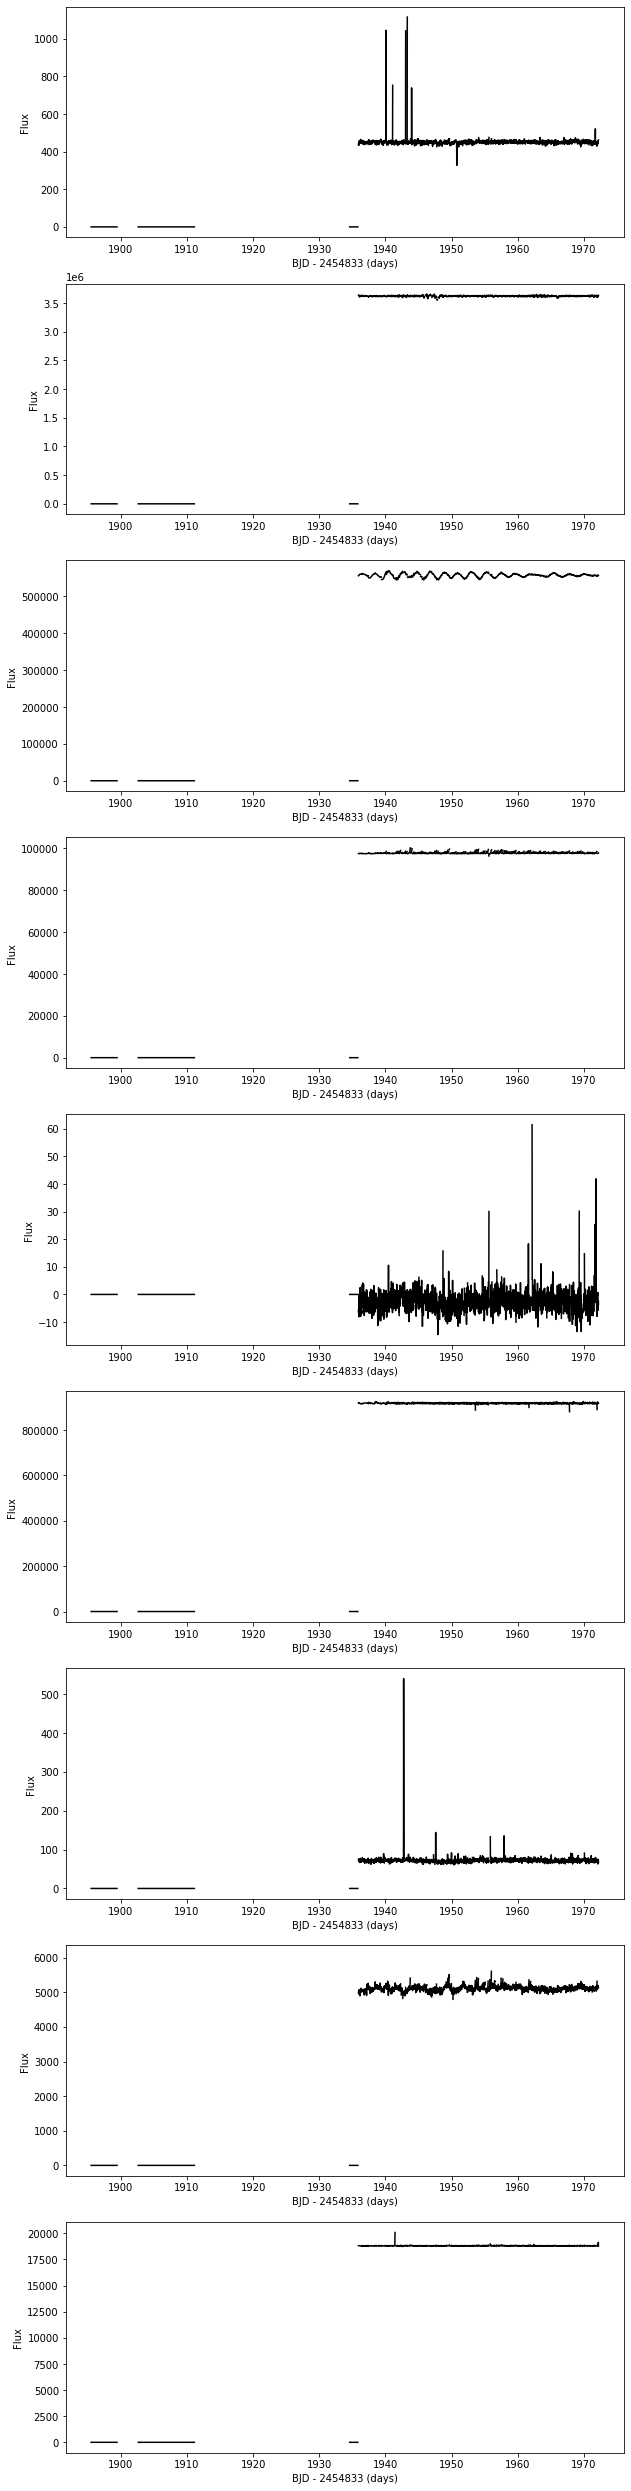

In [22]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1
plt.savefig('gdrive/My Drive/nanseries.png', dpi=300)


In [23]:
for i in range(len(bjds)):
  start = np.where(np.abs(fluxes[i]) >= 1)[0][0]
  bjds[i] = bjds[i][start:]
  fluxes[i] = fluxes[i][start:]
  fluxerrs[i] = fluxerrs[i][start:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


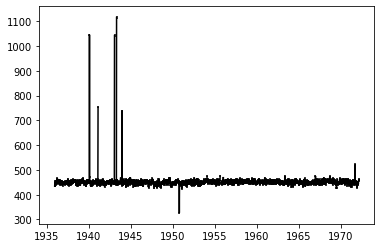

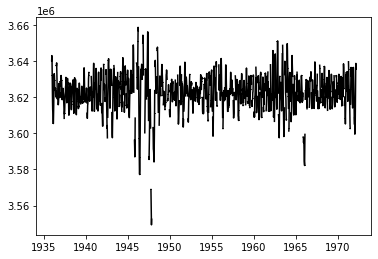

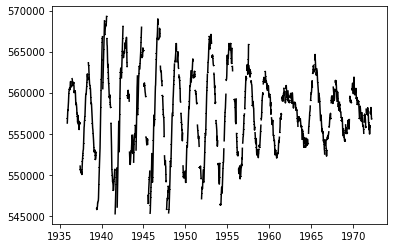

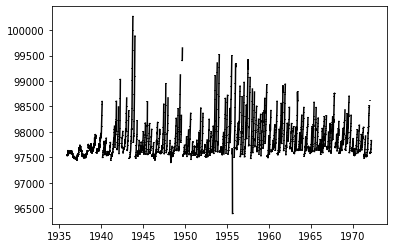

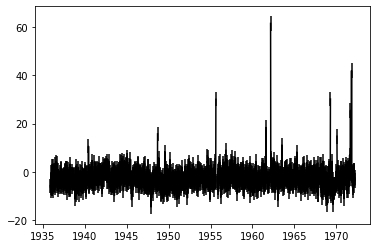

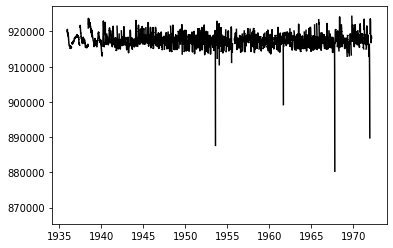

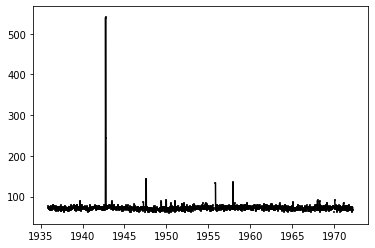

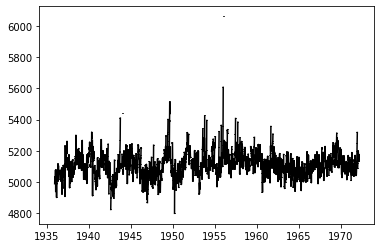

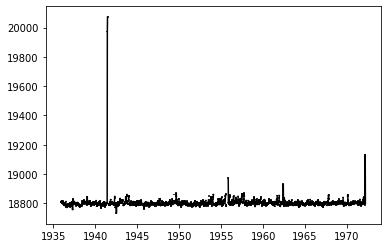

In [24]:
for i in range(0,900,100):
  plt.errorbar(bjds[i], fluxes[i], yerr=fluxerrs[i], c='k')
  plt.show()

In [0]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

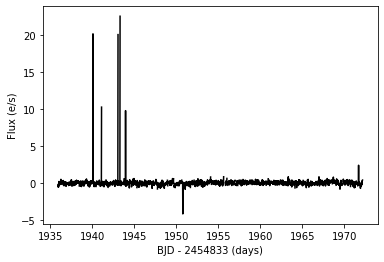

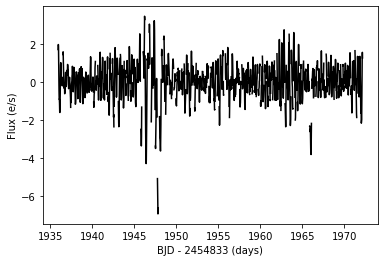

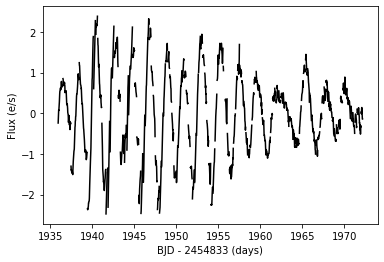

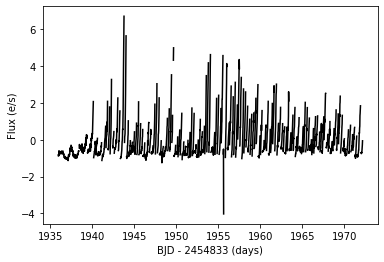

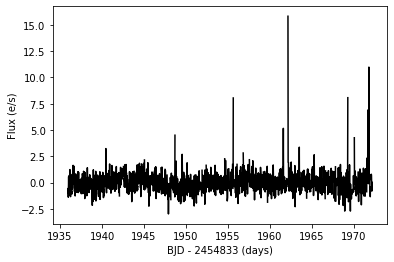

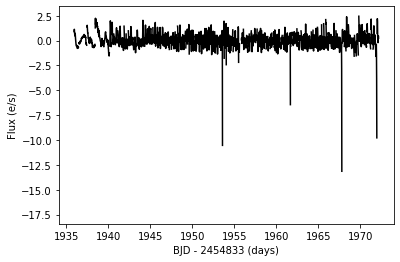

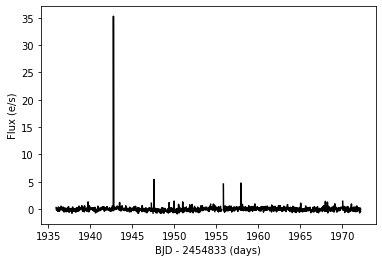

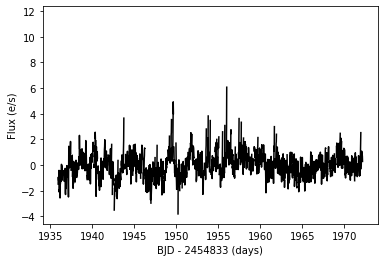

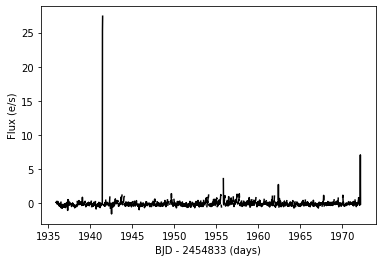

In [26]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [28]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

In [0]:
#Build list of # of consectutive nans in series
bjd_gaps = []
flux_gaps = []
fluxerr_gaps = []

for bjd in bjds:
  nancount = 0
  for i in range(len(bjd)):
    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == False):
      nancount += 1
      bjd_gaps.append(nancount)
      nancount = 0

    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == True):
      nancount += 1

for flux in fluxes:
  nancount = 0
  for i in range(len(flux)):
    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == False):
      nancount += 1
      flux_gaps.append(nancount)
      nancount = 0

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == True):
      nancount += 1

for fluxerr in fluxerrs:
  nancount = 0
  for i in range(len(fluxerr)):
    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == False):
      nancount += 1
      fluxerr_gaps.append(nancount)
      nancount = 0

    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == True):
      nancount += 1

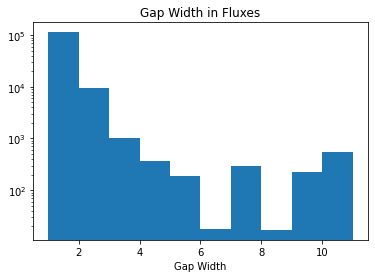

In [33]:
plt.hist(flux_gaps)
plt.yscale('log')
plt.xlabel('Gap Width')
plt.title('Gap Width in Fluxes')
plt.savefig('nanhist', dpi=200)

In [0]:
#Linear Interpolation
for flux in fluxes:
  for i in range(len(flux)):
    
      

## FFT Filtering

In [0]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [0]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, M=None, inv_box=False, gf_sig = 1, Filter='box'):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    plt.plot(freq, ps)
    plt.title("power spectrum")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power Spectral Density')
    #plt.xlim(0,100)
    #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    plt.plot(freq, spectrum)
    #plt.plot(freq[between], spectrum[between], alpha=0.5)
    plt.title("real fourier transform ")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Amplitude')
    #plt.xlim(0,100)
    #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    
    
    if Filter == 'box':
    
        filtered_spectrum = spectrum.copy()
    
        if inv_box == True:
            x_1 = np.arange(0, Low_cutoff, 0.1)
            x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
            plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[lc] = 0.
            filtered_spectrum[hc] = 0.
        else:
            x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
        ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
        filtered_spectrum = spectrum * ig
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()
        
    
    plt.plot(freq, filtered_spectrum, label="filtered spectrum")
    plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
    plt.title("Unfiltered vs. Filtered Spectrum")
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Amplitude')
    ldg = plt.legend(fontsize=12)
    #plt.xlim(0,100)
    #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
    plt.figure()
    
    
    fig = plt.figure(figsize=(15,10))
    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal
    plt.plot(t, filtered_signal, label="filtered signal")
    plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title("Unfiltered vs. Filtered Signal")
    #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
    plt.legend()
    #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [0]:
for i in range(len(allseries)-2)[::3]:
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(allseries[0])[0]
  Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(allseries[0], allseries[1], Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')


